In [103]:
import matplotlib.pyplot as plt
import numpy as np
from random import seed
from random import random
import os 
import time
from multiprocessing import Pool
import multiprocessing as mp
import tensorflow.compat.v1 as tf
from tensorflow.python import keras as keras
from tqdm import tqdm
from tqdm.auto import trange
from scipy.interpolate import interp1d

import pylab
from pycbc.waveform import get_td_waveform, get_fd_waveform
import pycbc.noise
import pycbc.psd
import pycbc

import seaborn as sns
plt.style.use("seaborn")

NUM_PARALLEL_EXEC_UNITS = 12

os.environ["OMP_NUM_THREADS"] = "NUM_PARALLEL_EXEC_UNITS"

os.environ["KMP_BLOCKTIME"] = "30"

os.environ["KMP_SETTINGS"] = "1"

os.environ["KMP_AFFINITY"]= "granularity=fine,verbose,compact,1,0"

In [132]:
# Helper functions (see also https://www.tensorflow.org/tutorials/load_data/tf_records)
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def write_tfrecords_file(out_path: str, images: np.ndarray, labels: np.ndarray) -> None:
    """Write all image-label pairs into a single .tfrecord file.
    :param out_path: File path of the .tfrecord file to generate or overwrite.
    :param images: array with first dimension being the image index. Every images[i].tostring() is
        serialized and written into the file as 'image': wrap_bytes(img_bytes)
    :param labels: 1d array of integers. labels[i] is the label of images[i]. Written as 'label': wrap_int64(label)"""
    assert len(images) == len(labels)
    #print(labels)
    #print(images)
    with tf.io.TFRecordWriter(out_path) as writer:  # could use writer_options parameter to enable compression
        #print(range(len(labels)))
        for i in range(len(labels)):
            img_bytes = images[i].tostring()  # Convert the image to raw bytes.
            label = labels[i]
            #data = {'image': _bytes_feature(img_bytes), 'label': _int64_feature(label)}
            #print(images[i].flatten())
            #print(label)
            data = {'image': tf.train.Feature(float_list=tf.train.FloatList(value=images[i].flatten())), 'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))}
            feature = tf.train.Features(feature=data)  # Wrap the data as TensorFlow Features.
            example = tf.train.Example(features=feature)  # Wrap again as a TensorFlow Example.
            serialized = example.SerializeToString()  # Serialize the data.
            writer.write(serialized)  # Write the serialized data to the TFRecords file.

#def npy_to_tfrecords(...):
#    # write records to a tfrecords file
#    writer = tf.python_io.TFRecordWriter(output_file)
#
#    # Loop through all the features you want to write
#    for ... :
#       #let say X is of np.array([[...][...]])
#       #let say y is of np.array[[0/1]]
#
#      # Feature contains a map of string to feature proto objects
#        feature = {}
#        feature['X'] = tf.train.Feature(float_list=tf.train.FloatList(value=X.flatten()))
#        feature['y'] = tf.train.Feature(int64_list=tf.train.Int64List(value=y)
#        # Construct the Example proto object
#        example = tf.train.Example(features=tf.train.Features(feature=feature)
#        # Serialize the example to a string
#        serialized = example.SerializeToString()
#        # write the serialized objec to the disk
#        writer.write(serialized)
#    writer.close()
    
# generates training and validation data and saves it on disk

# equations in https://arxiv.org/pdf/1611.03703.pdf

def signal_generator(m1_min,m1_max,m2_min,m2_max,m1_num,m2_num,n_noise,d,fold,train,chunk_number,n_timesteps):
    
    params, event, signal, noise, SNR, length = [], [], [], [], [], []

    n_bbh = m1_num*m2_num # total number of samples
    
    m1_list = np.linspace(m1_min,m1_max,m1_num)
    m2_list = np.linspace(m2_min,m2_max,m2_num)
    params = [(x,y) for x in m1_list for y in m2_list] # contains all possible combinations of m1 and m2
    
    # Paramaters for noise generation
    # The color of the noise matches a PSD which you provide
    flow = 30.0
#     delta_f = 1.0 / 16
    
    delta_t = 1.0 / n_timesteps
        
    for i in tqdm(range(0,n_bbh)):

        m1 = params[i][0]
        m2 = params[i][1]
#         print(m1,m2)
        hp, hc = get_td_waveform(approximant='IMRPhenomD', # generates the time-domain strains
                         mass1=m1,
                         mass2=m2,
                         delta_t=delta_t,
                         f_lower=15,
                         distance=d)
        
        hp.start_time+=hp.duration-hp.sample_times[-1] # shifts the event so that it starts at t=0
        hp.start_time-=hp.sample_times[0] 
        
        delta_f = 1.0 / hp.duration
        flen = int(n_timesteps / delta_f) + 1

        psd = pycbc.psd.analytical.AdvVirgo(flen, delta_f, flow)
        
        # generating hp.duration seconds of noise at 4096 Hz
        
        tsamples = int(hp.duration / delta_t)
        ts = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=None)

        # calculating SNR
#         tstilde = ts.to_frequencyseries()
#         snr = pycbc.filter.matched_filter(hp, tstilde, psd=psd,
#                                       low_frequency_cutoff=flow)
#         snr=np.abs(snr)
        
        # resampling event so that it is composed of n_timesteps points and lasts 1 seconds
        time_resampled = np.linspace(hp.duration-0.01-1,hp.duration-0.01,n_timesteps)
        spl = interp1d(hp.sample_times, hp, kind='cubic')
        event_resampled = spl(time_resampled)
        
        spl = interp1d(ts.sample_times, ts, kind='cubic')
        noise_resampled = spl(time_resampled)
        signal_resampled = event_resampled + noise_resampled
        
        sigma = np.std(noise_resampled) # std of the noise
        SNR.append(np.abs(event_resampled).max()/sigma)
        
        # normalising event, signal to the same max
        event_resampled = event_resampled/1.0e-21
        signal_resampled = signal_resampled/1.0e-21
        
        #event.append(event_resampled/signal_resampled.max()) # event contains only the clean simulated event (only plus polarisation)
        event.append(event_resampled) # event contains only the clean simulated event (only plus polarisation)
        
        #signal.append(signal_resampled/signal_resampled.max()) # signal contains the event + noise
        signal.append(signal_resampled) # signal contains the event + noise        

    for i in tqdm(range(0,n_noise)):
        
        # generating 4 seconds of noise
        tsamples = int(4 / delta_t)
        ts = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=None)
        
        time_resampled = np.linspace(0,ts.sample_times[-1],n_timesteps)
        spl = interp1d(ts.sample_times, ts, kind='cubic')
        noise_resampled = spl(time_resampled)
        #noise.append(noise_resampled/noise_resampled.max())
        noise.append(noise_resampled/1.0e-21)
        
    clean_strain = np.real(np.asarray(event, dtype=np.float64).reshape((n_bbh,n_timesteps)))
    noisy_strain = np.real(np.asarray(signal, dtype=np.float64).reshape((n_bbh,n_timesteps)))
    
    SNR = np.real(np.asarray(SNR, dtype=np.float64).reshape((n_bbh,1)))
    pure_noise = np.real(np.asarray(noise, dtype=np.float64).reshape((n_noise,n_timesteps)))

    clean_strain = np.hstack((clean_strain,np.ones((n_bbh,1),dtype=np.int))) # add label 1 to signals
    clean_strain = np.hstack((clean_strain,np.linspace(0,n_bbh-1,n_bbh).reshape(n_bbh,1))) # add unique identifier for all signals

    noisy_strain = np.hstack((noisy_strain,np.ones((n_bbh,1),dtype=np.int))) # add label 1 to signals
    noisy_strain = np.hstack((noisy_strain,np.linspace(0,n_bbh-1,n_bbh).reshape(n_bbh,1))) # add unique identifier for all signals
    noisy_strain = np.hstack((noisy_strain,SNR)) # add SNR feature

    pure_noise = np.hstack((pure_noise,np.zeros((n_noise,1),dtype=np.int))) # add label 0 to pure noise
    pure_noise = np.hstack((pure_noise,np.zeros((n_noise,1)))) # add 1 placeholder column to match dimensions with noisy_strain
    pure_noise = np.hstack((pure_noise,np.zeros((n_noise,1)))) # add SNR feature (=0 for noise)

    samples = np.vstack((noisy_strain,pure_noise))

    # ordering by decreasing SNR
    ind_samples = (-samples[:,-1]).argsort() 
    samples = samples[ind_samples]
    #np.savetxt('samples.txt',samples)
    
    ind_noisy_strain = (-noisy_strain[:,-1]).argsort() 
    noisy_strain = noisy_strain[ind_noisy_strain]
    clean_strain = clean_strain[ind_noisy_strain]
    
    ind_SNR = (-SNR[:,-1]).argsort() 
    SNR = SNR[ind_SNR]
    
    if train:
        # saving data to TFRecords files
        save_to_tfrecords(fold,samples,train,chunk_number)
    else:
        save_to_txt(fold,samples,clean_strain,train,chunk_number)
    
    return samples, noisy_strain, clean_strain, SNR, pure_noise, params

def data_generator(n_chunks,n_bbh,n_noise,parallel,n_procs,d0):
    
    if(n_bbh%n_chunks!=0):
        raise Exception('ERROR: n_bbh must be divisible by n_chunks.\n')
        
    print('\n Number of data chunks: ',n_chunks,'.\n')
    print('\n Number of signals + noises in each chunk: ',n_bbh,' signals + ',n_noise,' noises. \n')

    # Generating data
    print("\n Generating data... \n")

    if parallel:
    
        start_time = time.time()
        p = Pool(n_procs)

        data = [(m1_min,m1_max,m2_min,m2_max,m1_num,m2_num,n_noise,d0*(1+i*0.1),fold,train,i,n_timesteps) for i in range(0,n_chunks)]
        results = p.starmap(signal_generator, data)

        p.close()
        
        results = np.asarray(results)

        samples,noisy_strain,clean_strain,SNR,pure_noise,params = [], [], [], [], [], []
        
        print("Formatting data.\n")
        for i in tqdm(range(n_chunks)):
                    
            samples_new = results[i][0]
            noisy_strain_new = results[i][1]
            clean_strain_new = results[i][2]
            SNR_new = results[i][3]
#             print(SNR_new)
            pure_noise_new = results[i][4]
            params_new = results[i][5]
        
            
            if i==0:
                samples = samples_new
                noisy_strain = noisy_strain_new
                clean_strain = clean_strain_new
                SNR = SNR_new
                pure_noise = pure_noise_new
                params = params_new
            else:
                samples = np.vstack((samples,samples_new))
                noisy_strain = np.vstack((noisy_strain,noisy_strain_new))
                clean_strain = np.vstack((clean_strain,clean_strain_new))
                SNR = np.vstack((SNR,SNR_new))
                pure_noise = np.vstack((pure_noise,pure_noise_new))
                params = np.vstack((params,params_new))


        end_time = time.time()
        print("\n Data generated and saved. It took ",end_time-start_time,"s. \n")
        
    else:
        
        start_time = time.time()
        for i in range(0,n_chunks):
            print('Computing chunk number ',i+1,'/',n_chunks)
            samples_new, noisy_strain_new, clean_strain_new, SNR_new, pure_noise_new, params_new = signal_generator(m1_min,m1_max,m2_min,m2_max,m1_num,m2_num,n_noise,d0*(1+i*0.3),fold,train,i,n_timesteps)
            if i==0:
                samples, noisy_strain, clean_strain, SNR, pure_noise, params = samples_new, noisy_strain_new, clean_strain_new, SNR_new, pure_noise_new, params_new
            else:
                samples = np.vstack((samples,samples_new))
                noisy_strain = np.vstack((noisy_strain,noisy_strain_new))
                clean_strain = np.vstack((clean_strain,clean_strain_new))
                SNR = np.vstack((SNR,SNR_new))
                pure_noise = np.vstack((pure_noise,pure_noise_new))
                params = np.vstack((params,params_new))
        end_time = time.time()
        print("\n Data generated and saved. It took ",end_time-start_time,"s. \n")
        
    return samples,noisy_strain,clean_strain,SNR,pure_noise,params

def save_to_tfrecords(fold,samples,train,chunk_number):
    
    # Save training and validation data as TFRecords

    n_tot = samples.shape[0]   
#     print(samples.shape)
#     samples = samples.reshape((n_tot,n_timesteps+3))
    
    # WARNING: if you want to save samples ordered by SNR, the evaluation samples
    # must be picked with a different pattern, not the first 1/5th
    #np.random.shuffle(samples)

    x_train = np.delete(samples,-1, axis=1)
    x_train = np.delete(x_train,-1, axis=1)
    x_train = np.delete(x_train,-1, axis=1) # time series data
    y_train = samples[:,-3] # labels (0 or 1)
    #print(y_train)
    #print(x_train.shape)
    #print(x_train[1][6630:6635])
    x_train = np.asarray(x_train, dtype= np.float64).reshape(-1, n_timesteps, 1)
    y_train = np.asarray(y_train)



    IMAGE_WIDTH, NUM_OF_IMAGES, NUM_OF_CLASSES = n_timesteps, len(x_train), 2

    # using float32 to save memory. Must match type in parse_example(), tf.decode_raw(image_raw, tf.float32)
    # features_train = np.random.sample((NUM_OF_IMAGES, IMAGE_WIDTH, 1)).astype(np.float32)
    features_train = x_train.astype(np.float64)
    labels_train = y_train.astype(np.int) 
    #print(features_train[0][:-5])
    #print(labels_train[0])
    #np.savetxt('x_train.txt',features_train[1])
    #np.savetxt('y_train.txt',labels_train)
#     print(features_train[0])
#     print(labels_train[0])

    if train:
        rng = np.random.default_rng()
        eval_ind = rng.choice(len(x_train), int(len(x_train)/5), replace=False) # draws random indices to choose for evaluation data
        features_eval = features_train[eval_ind]  # use 1/5 of the total signals as evaluation data
        labels_eval = labels_train[eval_ind] 
#         print(features_eval[0])
#         print(labels_eval[0])
        #print(len(x_train),int(len(x_train)/5)+1)
        
        write_tfrecords_file(fold+"train_"+str(chunk_number)+".tfrecord", [element for i, element in enumerate(features_train) if i not in eval_ind],\
                                                                          [element for i, element in enumerate(labels_train) if i not in eval_ind])  
        write_tfrecords_file(fold+"eval_"+str(chunk_number)+".tfrecord", features_eval, labels_eval)  # this may take a while. Consider a progressbar
    else:
        write_tfrecords_file(fold+"test_"+str(chunk_number)+".tfrecord", features_train, labels_train)  
        
    return None

def save_to_txt(fold,samples,clean_strain,train,chunk_number):
    
    # Save training and validation data as TFRecords

    n_tot = samples.shape[0]   
#     print(samples.shape)
#     samples = samples.reshape((n_tot,n_timesteps+3))
    
    # WARNING: if you want to save samples ordered by SNR, the evaluation samples
    # must be picked with a different pattern, not the first 1/5th
    #np.random.shuffle(samples)
    
#     test_data = np.delete(samples,-1, axis=1)
#     test_data = np.delete(test_data,-1, axis=1)
 
    np.savetxt(fold+"test_"+str(chunk_number)+".txt", samples)   # x,y,z equal sized 1D arrays
    np.savetxt(fold+"clean_test_"+str(chunk_number)+".txt", clean_strain)   # x,y,z equal sized 1D arrays
    

# Training and validation data

In [133]:
# Setting the parameters for training and validation data

#seed(2) # setting the seed for random()
#np.random.seed(2) # setting the seed for np.random.normal()

n_procs = mp.cpu_count() # number of processes to spawn
n_chunks = n_procs #100 # number of chunks into which we divide the data

m1_min = 10
m1_max = 30

m2_min = 10
m2_max = 30

m1_num = 10
m2_num = 12
n_bbh = m1_num*m2_num
n_noise = n_bbh
# n_noise = int(n_bbh/3)

n_timesteps = 4096 # number of time points

d0 = 1000 # minimum distance (in Mpc)

parallel = True 

# Folder where training and validation data is saved
fold = '/mnt/c/Users/solda/Documents/code/ML/mycnn_gw/trvaldata/'

train=True

f=open(fold+'config.txt', 'w')
np.savetxt(f, [n_timesteps], delimiter=" ", fmt='%10.0d')
np.savetxt(f, [n_bbh+n_noise], delimiter=" ", fmt='%10.0d')
np.savetxt(f, [n_bbh], delimiter=" ", fmt='%10.0d')
np.savetxt(f, [n_noise], delimiter=" ", fmt='%10.0d')
np.savetxt(f, [n_chunks], delimiter=" ", fmt='%10.0d')
f.close() 

In [134]:
# Generate and save training and validation data
if __name__ == '__main__':
    
    samples, noisy_strain, clean_strain, SNR, pure_noise, params = data_generator(n_chunks,n_bbh,n_noise,parallel,n_procs,d0)



 Number of data chunks:  12 .


 Number of signals + noises in each chunk:  120  signals +  120  noises. 


 Generating data... 



100%|██████████| 120/120 [00:03<00:00, 31.66it/s]
/home/soldaman93/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
 98%|█████████▊| 118/120 [00:03<00:00, 22.23it/s]/home/soldaman93/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
/home/soldaman93/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
100%|██████████| 120/120 [00:03<00:00, 30.22it/s]
/home/soldaman93/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
100%|██████████| 120/120 [00:03<00:00, 30.10it/s]
/home/soldaman93/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
100%|██████████| 120/120 [00:03<00:00, 35.81it/s]
/home/soldaman93

Formatting data.



100%|██████████| 12/12 [00:00<00:00, 43.86it/s]


 Data generated and saved. It took  40.959999322891235 s. 



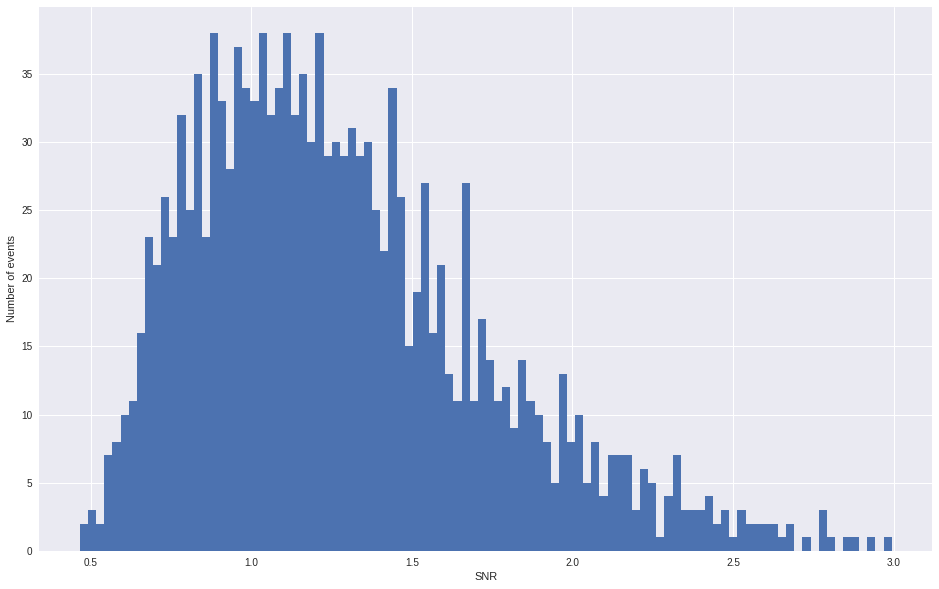

In [135]:
# Plot the SNR distribution of training/validation data
fig = plt.figure(figsize=(16,10))
plt.hist(SNR,bins=100)
plt.xlabel('SNR')
plt.ylabel('Number of events')
plt.show()
fig.savefig(fold+'snr_distribution.png', bbox_inches='tight', pad_inches=0.5, format='png')
# print(len(SNR))

In [111]:
noisy_strain[119][:]

array([ 8.21333082e-02, -1.52102821e-02, -8.48805557e-02,  1.37888906e-01,
       -9.63805882e-02, -1.21607105e-02,  1.04017219e-01, -1.06100138e-01,
        1.74185105e-02,  8.79633590e-02, -1.23064215e-01,  6.34023550e-02,
        3.28880250e-02, -8.10558749e-02,  4.97909124e-02,  1.30312365e-02,
       -3.45704472e-02, -5.24267063e-03,  5.40372768e-02, -4.57435845e-02,
       -2.60789046e-02,  9.97567573e-02, -1.10224686e-01,  5.59338950e-02,
        3.82784636e-03, -1.56191979e-02, -1.21641465e-02,  2.39117556e-02,
        1.69558717e-02, -8.37210395e-02,  1.11203618e-01, -6.19940586e-02,
       -3.48590516e-02,  1.09666734e-01, -1.13965752e-01,  5.86435927e-02,
        3.07493923e-03, -2.58233770e-02,  7.67833947e-03,  1.73438761e-02,
       -1.75872026e-02, -5.04110890e-03,  1.95333587e-02, -5.72747343e-04,
       -4.09512834e-02,  6.43540378e-02, -3.97063081e-02, -1.75230996e-02,
        5.69420624e-02, -4.34199336e-02, -4.26008720e-03,  3.13563493e-02,
       -7.25922529e-03, -

SNR =  0.46718856118372304


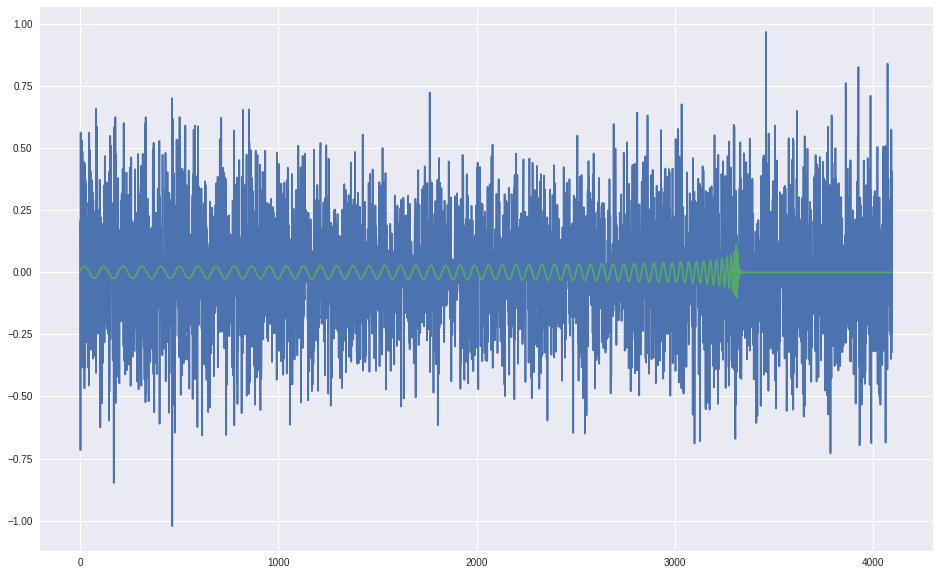

In [138]:
# Plot a specific signal
# Events are stored inside clean_strain and are
# ordered by decreasing SNR

#i_chunk = 0 # index of the chunk
#i_samples = 0
#i_noisy_strain = 1
#i_clean_strain = 2

i_sig = -1 # index of the signal 

event = clean_strain[i_sig][:-2]
signal = noisy_strain[i_sig][:-3]
noise = signal-event    

sigma = np.std(noise) # std of the noise

# print('SNR = ',np.max(np.abs(event))/np.sqrt(np.mean(noise**2))) # SNR
# print('SNR = ',np.max(np.abs(event))/sigma)
print('SNR = ',noisy_strain[i_sig][-1])

fig = plt.figure(figsize=(16,10))
plt.plot(signal)
plt.plot(event)
#plt.plot(noise)
#plt.xlim(6600,6700)

# Test data

In [139]:
# Setting the parameters for test data

#seed(3) # setting the seed for random()
#np.random.seed(3) # setting the seed for np.random.normal()

n_procs = mp.cpu_count() # number of processes to spawn
n_chunks = n_procs#100 # number of chunks into which we divide the data

m1_min = 10
m1_max = 30

m2_min = 10
m2_max = 30

m1_num = 12
m2_num = 6
n_bbh = m1_num*m2_num#-(m1_num*m2_num)%n_procs
n_noise = n_bbh

n_timesteps = 4096 # number of time points

d0 = 1000000 # minimum distance (in Mpc)

parallel = True

# Folder where test data is saved
fold = '/mnt/c/Users/solda/Documents/code/ML/mycnn_gw/testdata/'

train=False

f=open(fold+'config.txt', 'w')
np.savetxt(f, [n_timesteps], delimiter=" ", fmt='%10.0d')
np.savetxt(f, [n_bbh+n_noise], delimiter=" ", fmt='%10.0d')
np.savetxt(f, [n_bbh], delimiter=" ", fmt='%10.0d')
np.savetxt(f, [n_noise], delimiter=" ", fmt='%10.0d')
np.savetxt(f, [n_chunks], delimiter=" ", fmt='%10.0d')
f.close() 

In [140]:
# Generate and save test data
if __name__ == '__main__':
    
    samples, noisy_strain, clean_strain, SNR, pure_noise, params = data_generator(n_chunks,n_bbh,n_noise,parallel,n_procs,d0)



 Number of data chunks:  12 .


 Number of signals + noises in each chunk:  72  signals +  72  noises. 


 Generating data... 



100%|██████████| 72/72 [00:02<00:00, 28.55it/s]
/home/soldaman93/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
100%|██████████| 12/12 [00:00<00:00, 73.27it/s]

Formatting data.


 Data generated and saved. It took  28.83567976951599 s. 



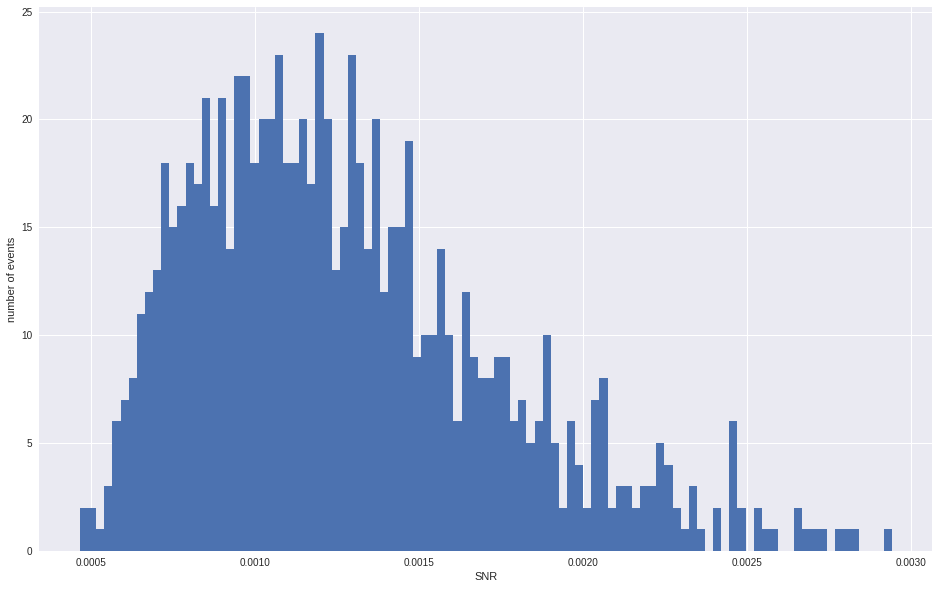

In [141]:
# Plot the SNR distribution of test data
fig = plt.figure(figsize=(16,10))
plt.hist(SNR,bins=100)
plt.xlabel('SNR')
plt.ylabel('number of events')
plt.show()
fig.savefig(fold+'snr_distribution.png', bbox_inches='tight', pad_inches=0.5, format='png')

SNR =  0.0024710019485338825


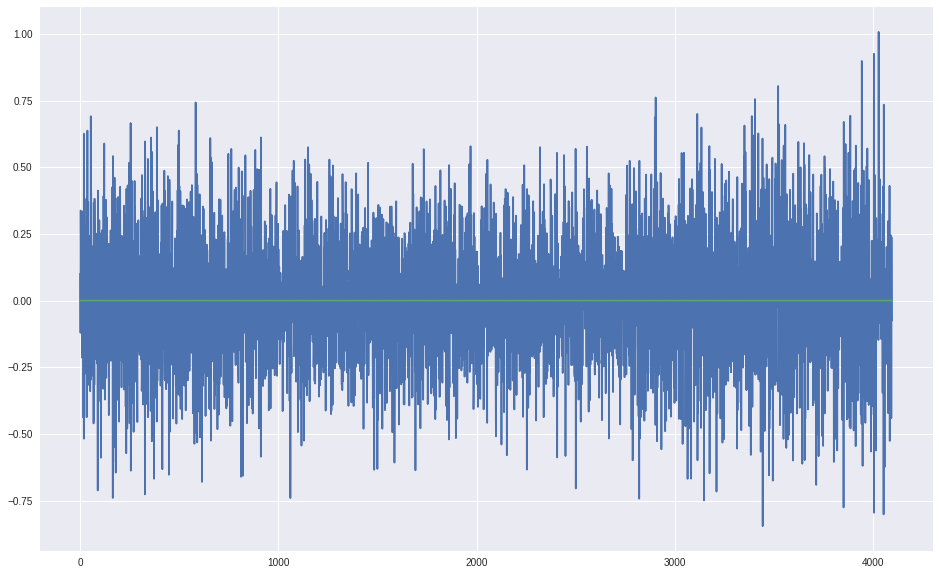

In [143]:
# Plot a specific signal
# Events are stored inside clean_strain and are
# ordered by decreasing SNR

#i_chunk = 0 # index of the chunk
#i_samples = 0
#i_noisy_strain = 1
#i_clean_strain = 2
i_sig = 10 # index of the signal inside the chunk

event = clean_strain[i_sig][:-2]
signal = noisy_strain[i_sig][:-3]
noise = signal-event    

sigma = np.std(noise) # std of the noise

# print('SNR = ',np.max(np.abs(event))/np.sqrt(np.mean(noise**2))) # SNR
# print('SNR = ',np.max(np.abs(event))/sigma)
print('SNR = ',noisy_strain[i_sig][-1])

fig = plt.figure(figsize=(16,10))

plt.plot(signal)
plt.plot(event)

In [126]:
from gwdama.io import GwDataManager
dm = GwDataManager("data")
event_gps = 1186746618  
dm = GwDataManager("data")
# Data from Virgo interferometer (ifo), labeled "V1". Other options are
# L1 (LIGO Livingston) and H1 (LIGO Hanford)
print("This may take some time... ",end='')
dm.read_gwdata(event_gps - 50, event_gps +10, ifo='V1')
print("done!")

This may take some time... done!


In [127]:
print(dm)

data:
  └── strain

  Attributes:
     dama_name : data
    time_stamp : 21-06-15_11h32m29s



In [128]:
# Let's associate the dataset to a variable, for convenience
dts=dm['strain']

# and see its attributes/metadata
dts.show_attrs

   channel : None
sample_rate : 4096.0
        t0 : 1186746568.0
      unit : 



In [129]:
dts.attrs['unit'] = 'strain'
dts.attrs['channel'] = 'Virgo strain data'

# and check the result
dts.show_attrs

   channel : Virgo strain data
sample_rate : 4096.0
        t0 : 1186746568.0
      unit : strain



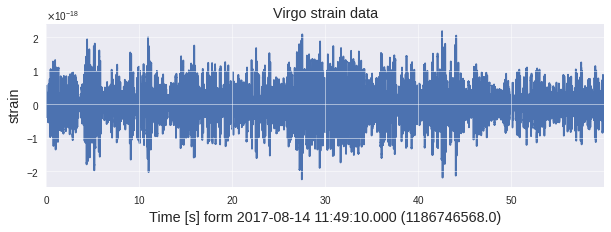

In [130]:
dts.plot()

In [11]:
# !jupyter nbconvert --to script data_generator.ipynb